### SQL-Abfragen in Relationale Algebra konvertieren

Projection
    Selection
        CrossProduct
            ThetaJoin
                Selection
                    Relation
                Relation
            SubqueryScan
                Projection
                    Map
                        GroupBy
                            Selection
                                CrossProduct
                                    Relation
                                    ThetaJoin
                                        Selection
                                            Relation
                                        Relation
π (s.name, e.course)
  <- σ (e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- <<Scalar Subquery Scan>>
        <- π (MIN(e2.grade))
          <- γ (e2.grade: MIN(e2.grade))
            <- ⋈ ϴ=(s.id = e2.sid)
              <- ⋈ ϴ=(s.id = e.sid)
                <- s
                <- e
              <- e2
π (s.name, e.cours

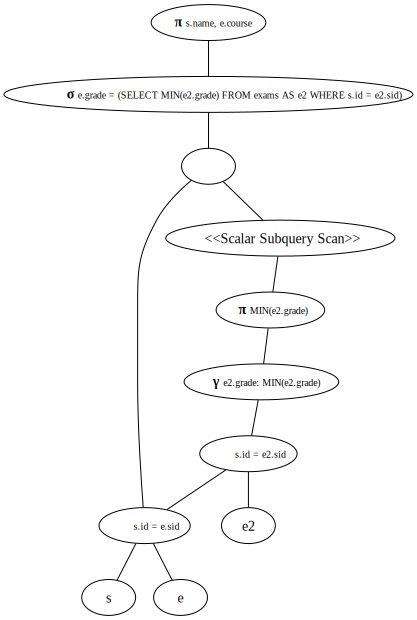

In [1]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)

print(parser.str_relalg(relalg_query_2))
print(relalg_query_1.inspect())
print(relalg_query_2.inspect())

opt_vis.plot_relalg(relalg_query_1)

### Optimierung

Projection
  <- Selection
    Parent: Projection
    Predicate: e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid)
    <- CrossProduct
      Parent: Selection
      <- ThetaJoin
        Parent: ThetaJoin
        Predicate: s.id = e.sid
        Sideways Pass: ['CrossProduct']
        <- Relation
          Parent: ThetaJoin
        <- Relation
          Parent: ThetaJoin
      <- SubqueryScan
        Parent: CrossProduct
        <- Projection
          Parent: SubqueryScan
          <- GroupBy
            Parent: Projection
            <- ThetaJoin
              Parent: GroupBy
              Predicate: s.id = e2.sid
              <- ThetaJoin
                Parent: ThetaJoin
                Predicate: s.id = e.sid
                Sideways Pass: ['CrossProduct']
                <- Relation
                  Parent: ThetaJoin
                <- Relation
                  Parent: ThetaJoin
              <- Relation
                Parent: ThetaJoin
⋈ ϴ=(s.id = e.sid)
  <

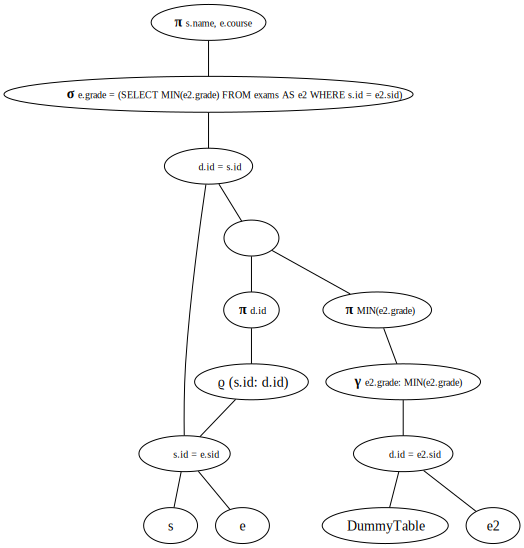

In [2]:
from src.optimizer.push_down_manager import PushDownManager
from src.utils.utils import Utils
from src.optimizer.optimizer import Optimizer

utils = Utils()
print(utils.detailed_structure_visualization(relalg_query_1))

pushDownManager = PushDownManager(utils)
optimizer = Optimizer(utils)
t1, t2, dependent_join, d = optimizer.optimize_unnesting(relalg_query_1)

print(t1.inspect())
print(t2.inspect())
print(dependent_join.inspect())
print(d.inspect())

opt_vis.plot_relalg(d)


Projection
  <- Selection
    Parent: Projection
    Predicate: e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid)
    <- ThetaJoin
      Parent: Selection
      Predicate: d.id = s.id
      <- ThetaJoin
        Parent: ThetaJoin
        Predicate: s.id = e.sid
        Sideways Pass: ['Rename']
        <- Relation
          Parent: ThetaJoin
          Sideways Pass: ['ThetaJoin']
        <- Relation
          Parent: ThetaJoin
          Sideways Pass: ['ThetaJoin']
      <- Projection
        Parent: ThetaJoin
        <- GroupBy
          Parent: Projection
          <- ThetaJoin
            Parent: GroupBy
            Predicate: d.id = e2.sid
            <- Projection
              Parent: ThetaJoin
              <- Rename
                Parent: Projection
                <- ThetaJoin
                  Parent: ThetaJoin
                  Predicate: s.id = e.sid
                  Sideways Pass: ['Rename']
                  <- Relation
                    Parent: The

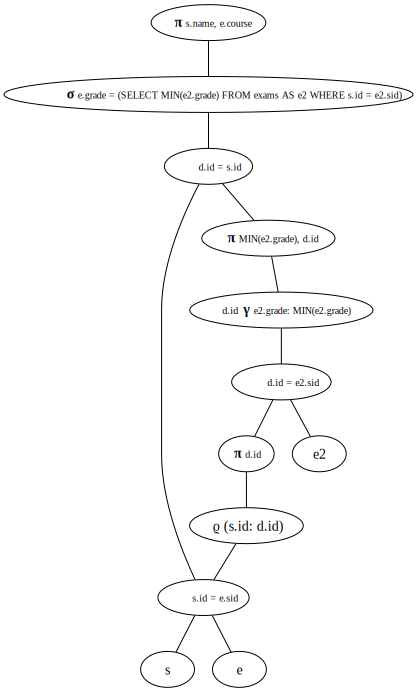

In [3]:
push_down = pushDownManager.push_down(d)
print(utils.detailed_structure_visualization(push_down))
opt_vis.plot_relalg(push_down)

In [4]:
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
print(query_generator.generate_sql_from_relalg(push_down))

SELECT e.course, s.id, s.name, e.grade FROM students AS s, exams AS e WHERE s.id = e.sid;
outerquery AS (SELECT e.course, s.id, s.name, e.grade FROM students AS s, exams AS e WHERE s.id = e.sid)
dup_elim_outerquery AS (SELECT DISTINCT id FROM outerquery)
SELECT s.name, e.course FROM outerquery AS oq WHERE e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid);


AttributeError: 'SqlQuery' object has no attribute 'upper'